
## QAOA with Qiskit



Qiskit is an open-source SDK for working with quantum computers. [documentation](https://qiskit.org)

QAOA has already been implemented by Qiskit which directly extends VQE and inherits VQE’s optimization structure. However, QAOA uses its own fine-tuned ansatz, which comprises parameterized global x rotations and p different parameterizations of the problem hamiltonian.

```python
CLASSQAOA(optimizer=None, reps=1, initial_state=None, mixer=None, initial_point=None, gradient=None, expectation=None, include_custom=False, max_evals_grouped=1, callback=None, quantum_instance=None)
```

#### Important parameters:

__optimizer__: a classical optimizer

__reps__: the integer parameter p

__initial_point__: initial parameter values for the optimizer (optional) may be provided as the starting beta and gamma parameters

__quantum_instance__ : specify quantum instance or backend

Other parameters [here](https://qiskit.org/textbook/ch-applications/qaoa.html)

### MaxCut Implementation using Qiskit

Using Qiskit's implemetation of QAOA we can solve optimizational problems in just a few lines of code.

In [2]:
#import the useful modules and optimizers
import qiskit
import networkx as nx
import numpy as np
from qiskit import Aer
from qiskit.algorithms import QAOA
from qiskit_optimization import QuadraticProgram
from qiskit.algorithms.optimizers import ADAM, SLSQP, COBYLA
from qiskit_optimization.algorithms import MinimumEigenOptimizer

In [4]:
def quadratic_program_from_graph(graph: nx.Graph) -> QuadraticProgram:
    '''Constructs a QuadraticProblem from a given graph for a MAXCUT instance.
    Args:
        graph: Underlying graph of the problem
    Returns: 
        QuadraticProblem
    '''
    # get weight matrix from the graph
    weight_matrix = nx.adjacency_matrix(graph)
    shape = weight_matrix.shape
    size = shape[0]
    # build QUBO matrix Q from weight matrix
    qubo_matrix = np.zeros((size, size))
    qubo_vector = np.zeros(size)
    for i in range(size):
        for j in range(size):
            qubo_matrix[i,j] -= weight_matrix[i, j]
            qubo_vector[i] += weight_matrix[i,j]
    # define the quadraric program
    quadratic_program = QuadraticProgram('maxcut')
    for i in range(size):
        var_name = 'x_{}'.format(i)
        quadratic_program.binary_var(var_name)
    quadratic_program.maximize(quadratic=qubo_matrix, linear=qubo_vector, constant=0)
    #print(quadratic_program.export_as_lp_string())
    return quadratic_program

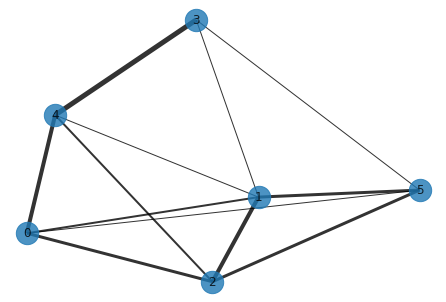

In [17]:
graph = nx.Graph()
# add nodes and edges
graph.add_nodes_from(np.arange(0,6,1))
edges = [(0,1,2.0), (0,2,3.0), (0,4,4.0), (0,5,1.0), (1,2,4.0), (1,3,1.0), (1,4,1.0), (1,5,3.0), (2,4,2.0), (2,5,3.0), (3,4,5.0), (3,5,1.0)]
graph.add_weighted_edges_from(edges)

weights = nx.get_edge_attributes(graph,'weight').values()

nx.draw(graph, with_labels=True, alpha=0.8, node_size=500, width=list(weights))

In [7]:
# define backend
backend = Aer.get_backend('qasm_simulator')
backend.shots = 1024

# implement qaoa as an eigen minizizer with qasm_simulator as the simulating backend 
# using the cobyla classical optimizer
qaoa = QAOA(optimizer=COBYLA(), quantum_instance=backend, reps=1, initial_point=[0.0, 0.0])
eigen_optimizer = MinimumEigenOptimizer(min_eigen_solver=qaoa)

# encode the problem graph as a quadratic program
qp = quadratic_program_from_graph(graph)

# solve
result = eigen_optimizer.solve(qp)
print(result)

optimal function value: 23.0
optimal value: [0. 1. 0. 0. 1. 1.]
status: SUCCESS


1.0

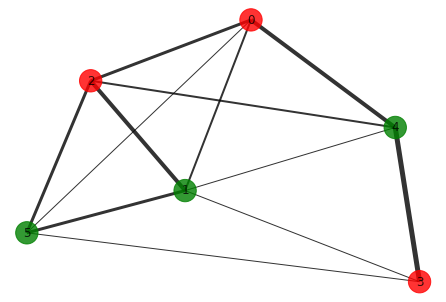

In [19]:
# color the nodes according to our result
color_map = []
for i in result:
    if i == 0.0:
        color_map.append("red")
    else:
        color_map.append("green")

# draw the graphs
nx.draw(graph, node_color = color_map, with_labels=True, alpha=0.8, node_size=500, width=list(weights))

*Prompt: Would you expect initial point (1,0) or (0,1) to perform better?*

Ans: (0, 1) would perform better
